# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute calibration matrix & undistort a test image

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib inline

# Prepare object points, like (0, 0, 0), (1, 0, 0), (2, 0, 0), ...., (6, 5, 0)
objp = np.zeros((6 * 9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # If found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

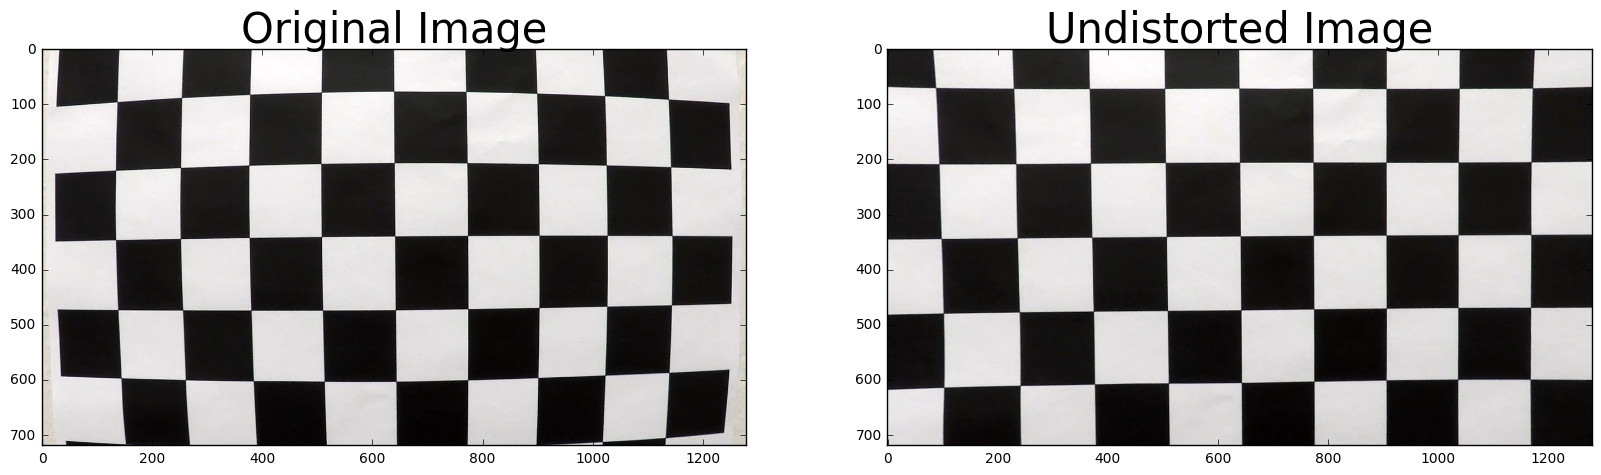

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
chess = cv2.imread('camera_cal/calibration1.jpg')
img_size = (chess.shape[1], chess.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None ,None)

# Little wrapper for cv2.undistort(...) 
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

chess_undist = undistort(chess)
cv2.imwrite('camera_cal/test_undist.jpg', chess_undist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(cv2.cvtColor(chess, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(chess_undist, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)
f.savefig('undistort_chess.jpg')

# Pipeline

## 1. Read image and apply undistortion

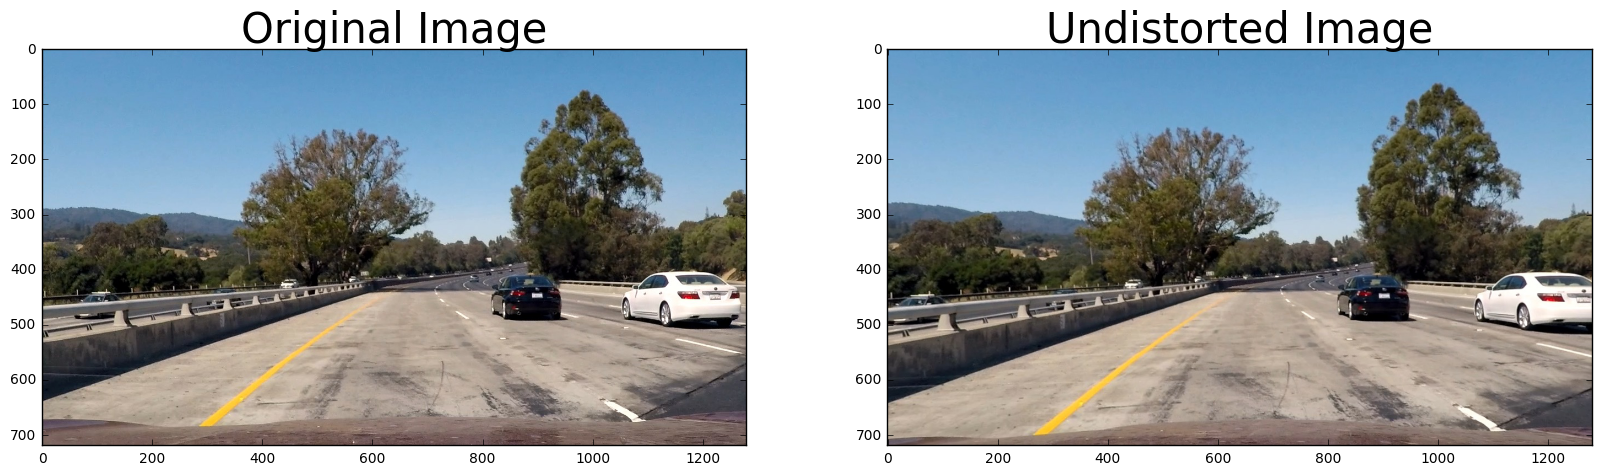

In [3]:
bgr = cv2.imread('test_images/test1.jpg')
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
img_size = (rgb.shape[1], rgb.shape[0])

rgb_undist = undistort(rgb)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(rgb)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(rgb_undist)
ax2.set_title('Undistorted Image', fontsize=30)
f.savefig('undistort.jpg')

## 2. Create binary image

### Trying S-channel isolation & thresholding

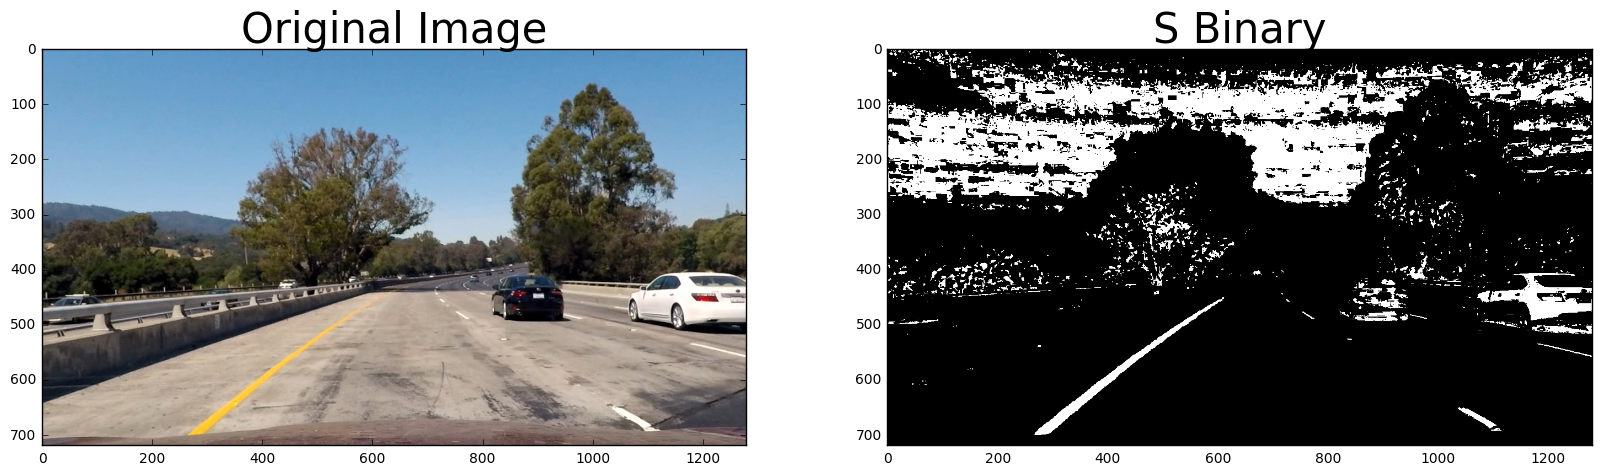

In [4]:
# Isolate and threshold S channel
def hls_select(rgb_undist, thresh=(0, 255)):
    hls_undist = cv2.cvtColor(rgb_undist, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls_undist[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Lowered minimum threshold to 125 to recognize yellow lines in test7.jpg and test8.jpg reliably
s_binary = hls_select(rgb_undist, thresh=(125, 255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(rgb_undist)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('S Binary', fontsize=30)
f.savefig('s_binary.jpg')

### Try out various gradients / thresholds

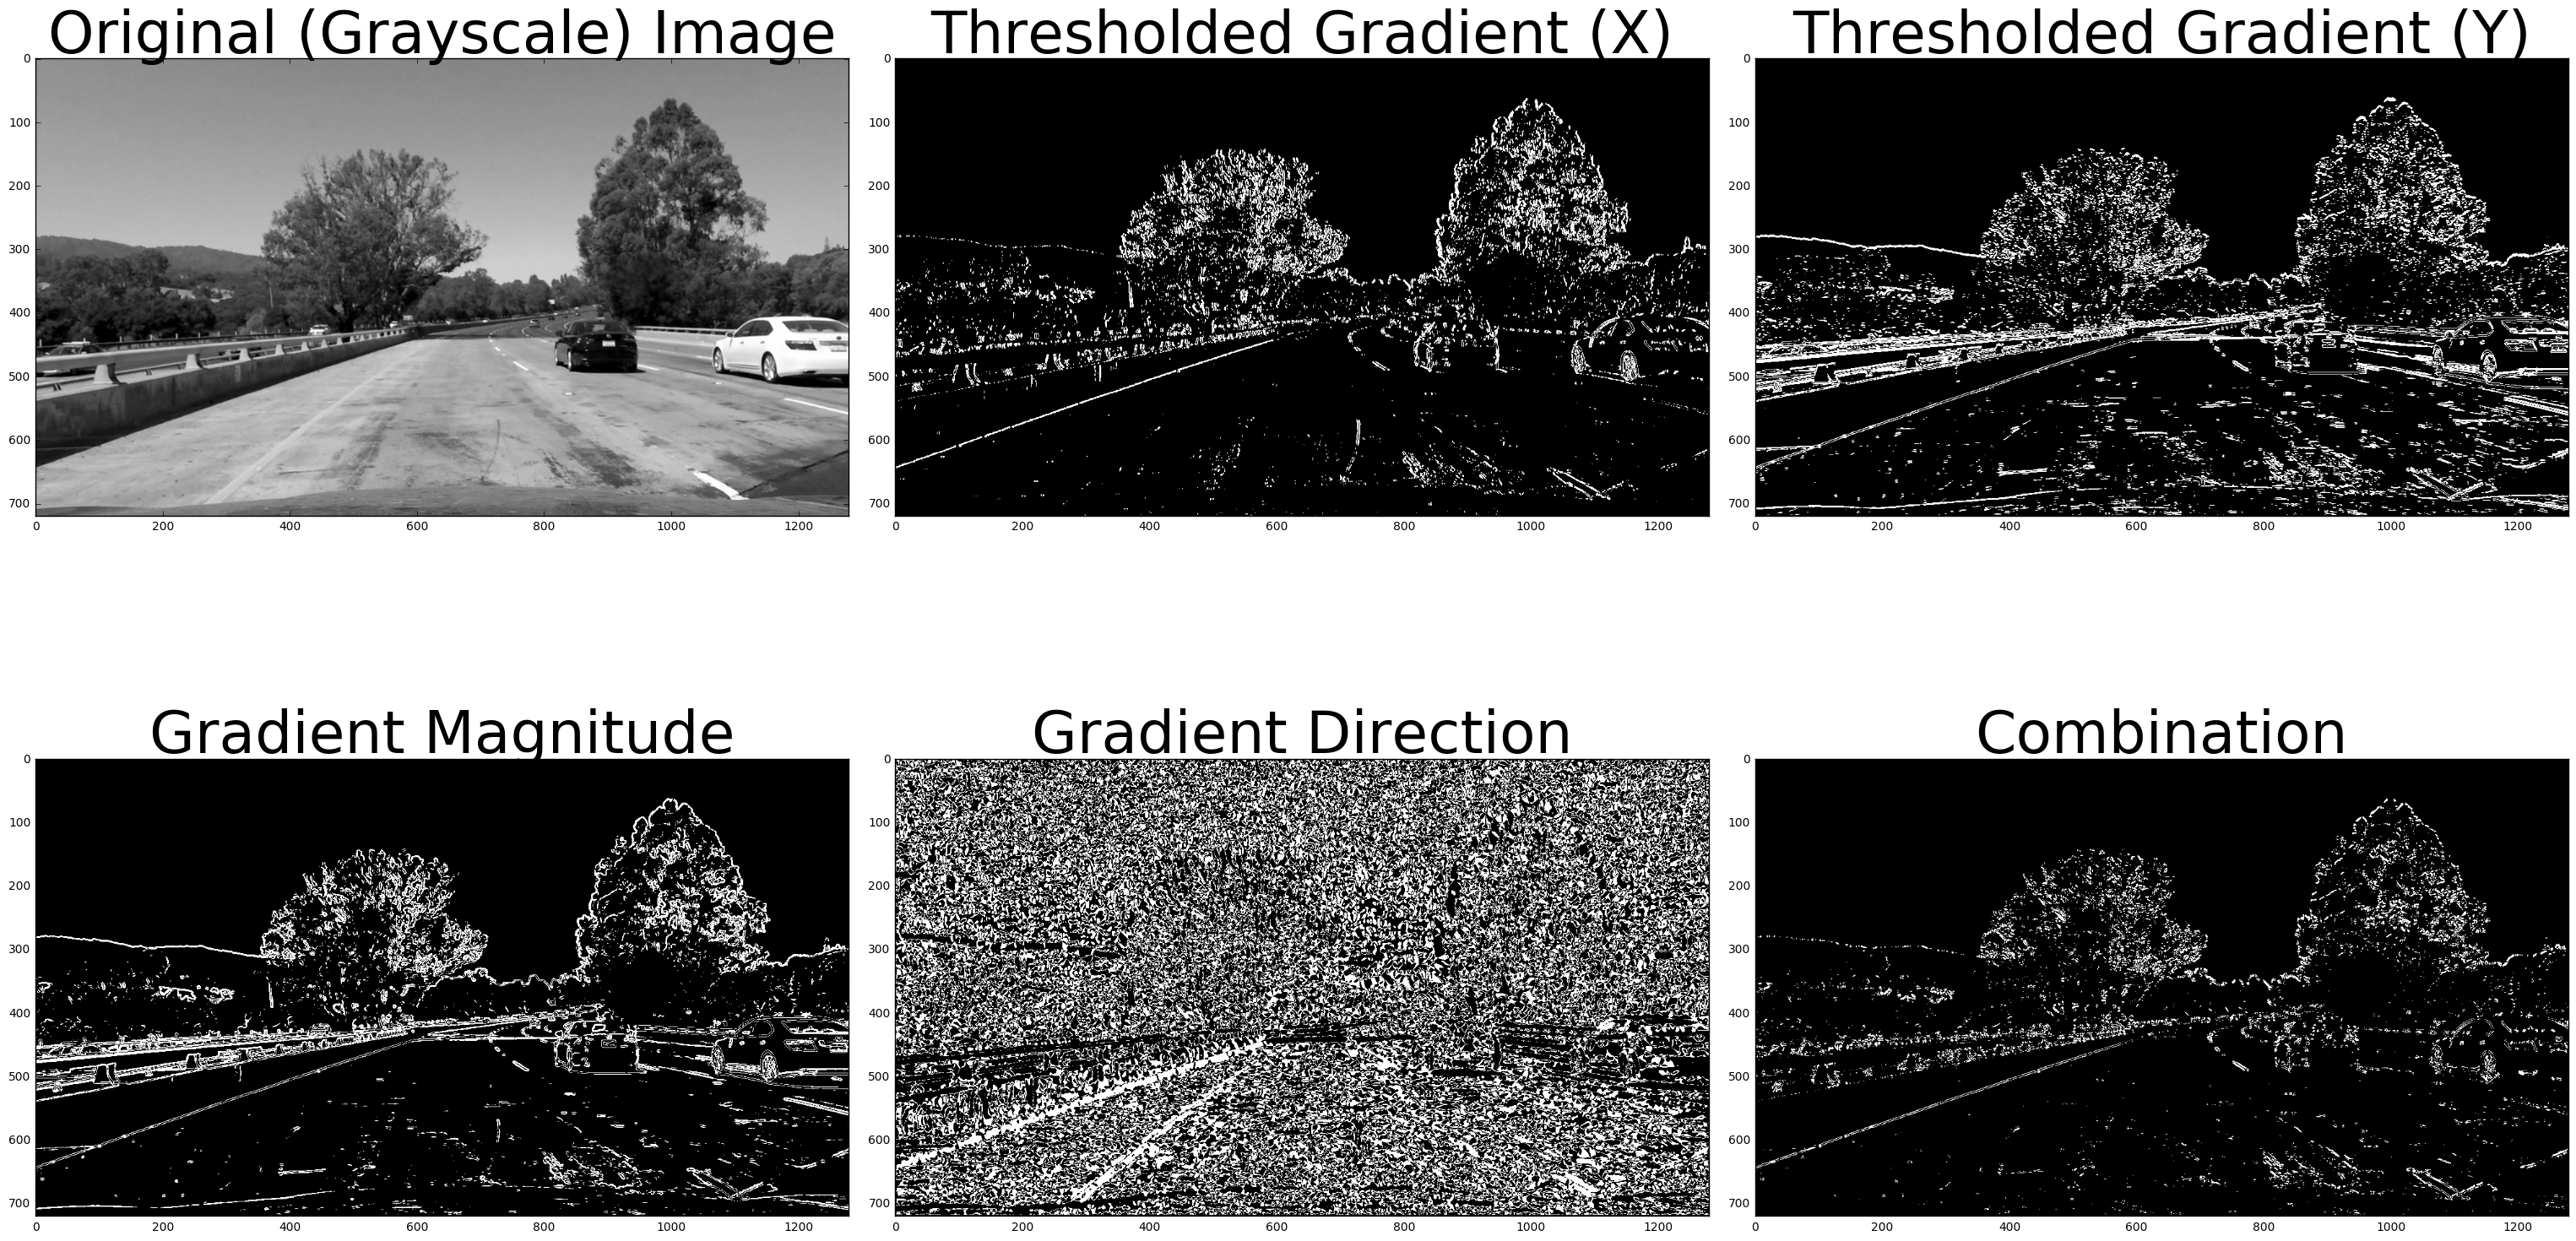

In [5]:
# Calculate directional gradient & apply threshold
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient is 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient is 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 3) Scale to 8-bit (0-255), then convert to np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # 4) Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output


# Calculate gradient magnitude & apply threshold
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 2) Calculate the magnitude 
    abs_sobel_xy = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # 3) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel_xy / np.max(abs_sobel_xy))
    
    # 4) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return binary_output


# Calculate gradient direction & apply threshold
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # 1) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 2) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    # 3) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_dir = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # 4) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(abs_dir)
    binary_output[(abs_dir >= thresh[0]) & (abs_dir <= thresh[1])] = 1
    
    return binary_output


# Sobel kernel size
ksize = 3

# Preprocess image
gray_undist = cv2.cvtColor(rgb_undist, cv2.COLOR_RGB2GRAY)
s_binary = hls_select(rgb_undist, thresh=(170, 255))

# Sobel x/y
grad_x = abs_sobel_thresh(gray_undist, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grad_y = abs_sobel_thresh(gray_undist, orient='y', sobel_kernel=ksize, thresh=(20, 100))

# Gradient magnitude
mag_binary = mag_thresh(gray_undist, sobel_kernel=ksize, mag_thresh=(30, 100))

# Gradient direction
dir_binary = dir_threshold(gray_undist, sobel_kernel=15, thresh=(0.7, 1.3))

# Combination
combined = np.zeros_like(dir_binary)
combined[((grad_x == 1) & (grad_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Visualize everything
f, ax = plt.subplots(2, 3, figsize=(30, 18))
f.tight_layout()
ax = ax.flatten()
ax[0].imshow(gray_undist, cmap='gray')
ax[0].set_title('Original (Grayscale) Image', fontsize=50)
ax[1].imshow(grad_x, cmap='gray')
ax[1].set_title('Thresholded Gradient (X)', fontsize=50)
ax[2].imshow(grad_y, cmap='gray')
ax[2].set_title('Thresholded Gradient (Y)', fontsize=50)
ax[3].imshow(mag_binary, cmap='gray')
ax[3].set_title('Gradient Magnitude', fontsize=50)
ax[4].imshow(dir_binary, cmap='gray')
ax[4].set_title('Gradient Direction', fontsize=50)
ax[5].imshow(combined, cmap='gray')
ax[5].set_title('Combination', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('various_gradients.jpg')

In [6]:
# Pre-pipeline to undistort an image and return a thresholded binary
def pre_pipeline(image, s_threshold=(170, 255), sobel_threshold=(20, 100), ksize=3, is_rgb=False):
    # Convert to RGB
    if is_rgb:
        rgb = image
    else:
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Size
    img_size = (rgb.shape[1], rgb.shape[0])

    # Undistort
    rgb_undist = undistort(rgb)
    
    # Convert to grayscale
    gray_undist = cv2.cvtColor(rgb_undist, cv2.COLOR_RGB2GRAY)

    # Isolate S channel
    s_binary = hls_select(rgb_undist, thresh=s_threshold)
    
    # Apply Sobel in x-direction
    grad_x = abs_sobel_thresh(gray_undist, orient='x', sobel_kernel=ksize, thresh=sobel_threshold)

    # Stack
    color_binary = np.dstack((np.zeros_like(grad_x), grad_x, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(grad_x)
    combined_binary[(s_binary == 1) | (grad_x == 1)] = 1

    return rgb_undist, color_binary, combined_binary

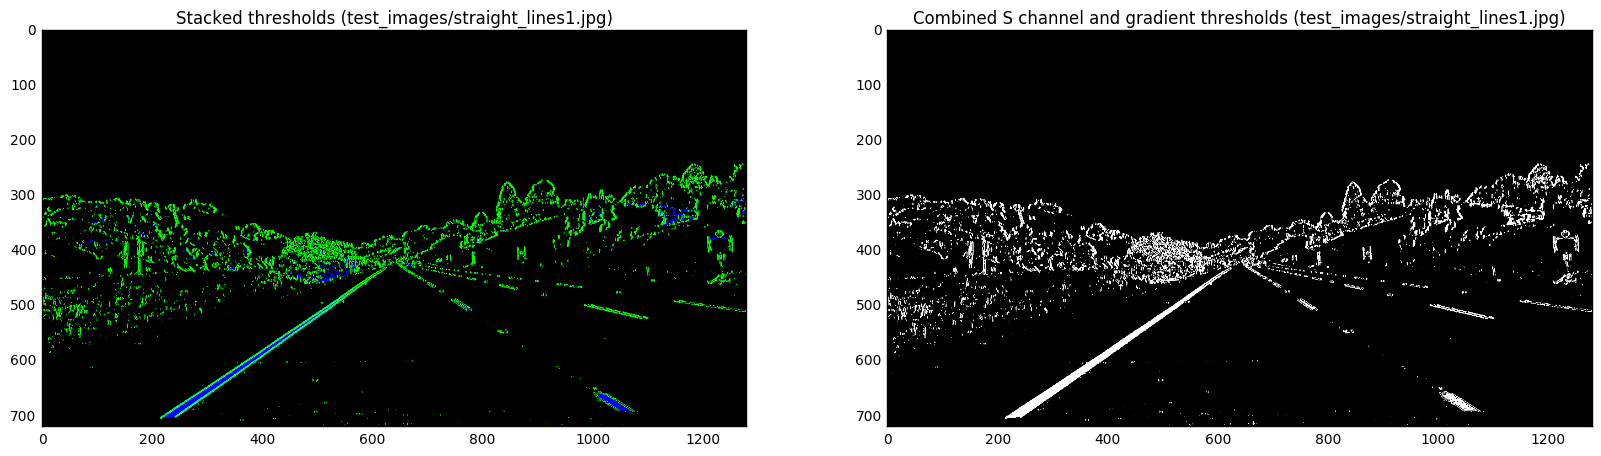

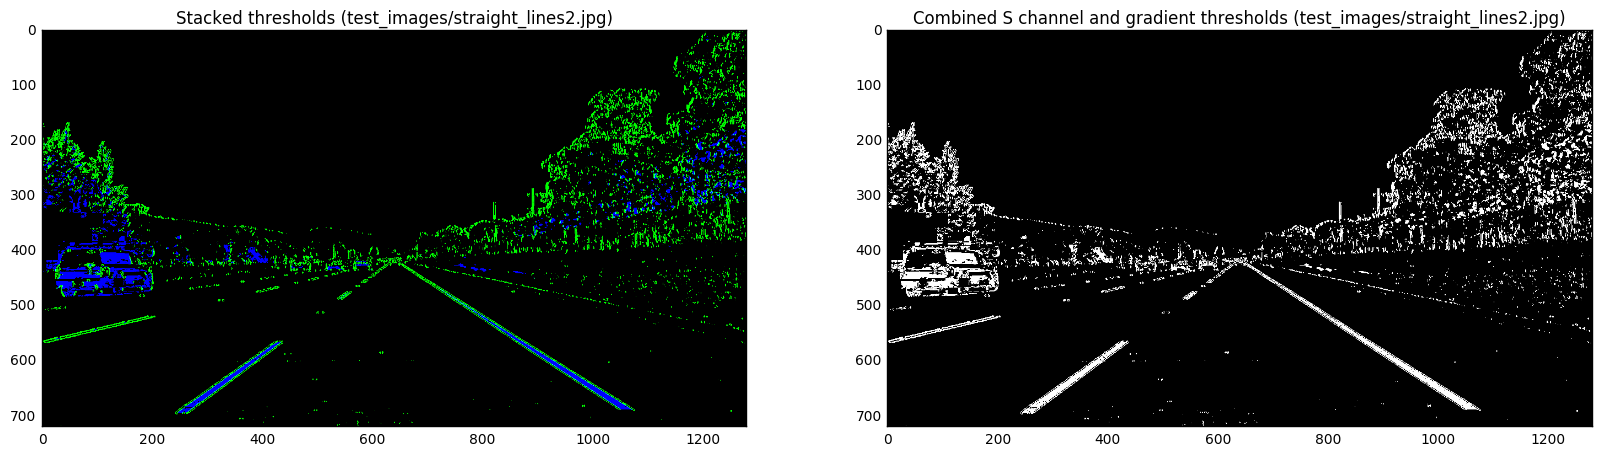

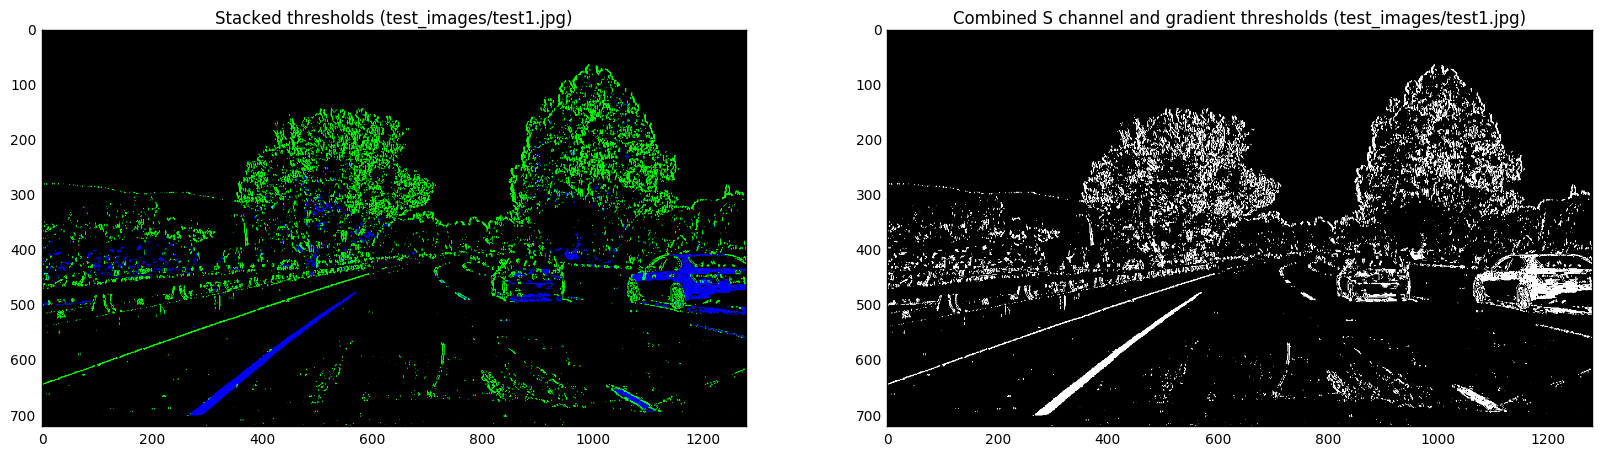

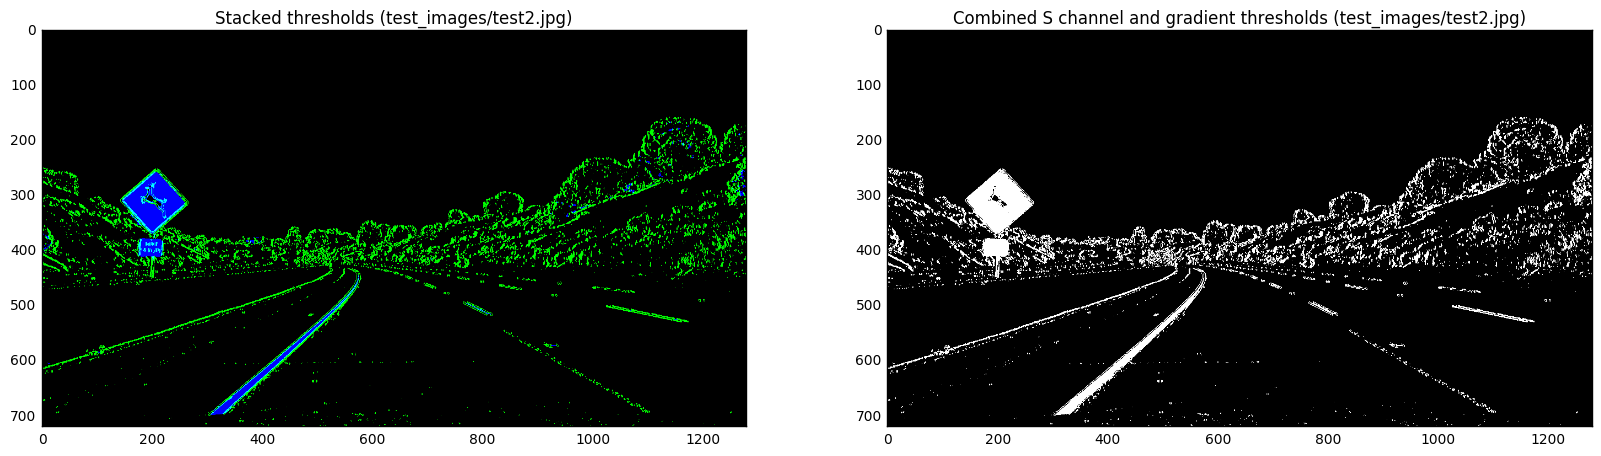

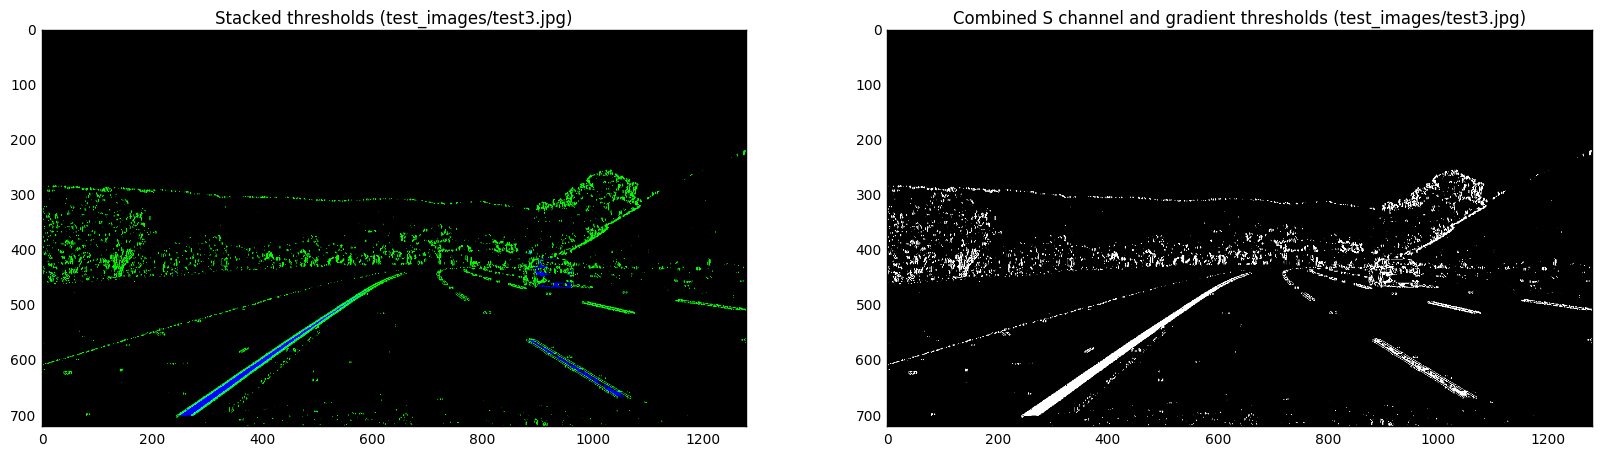

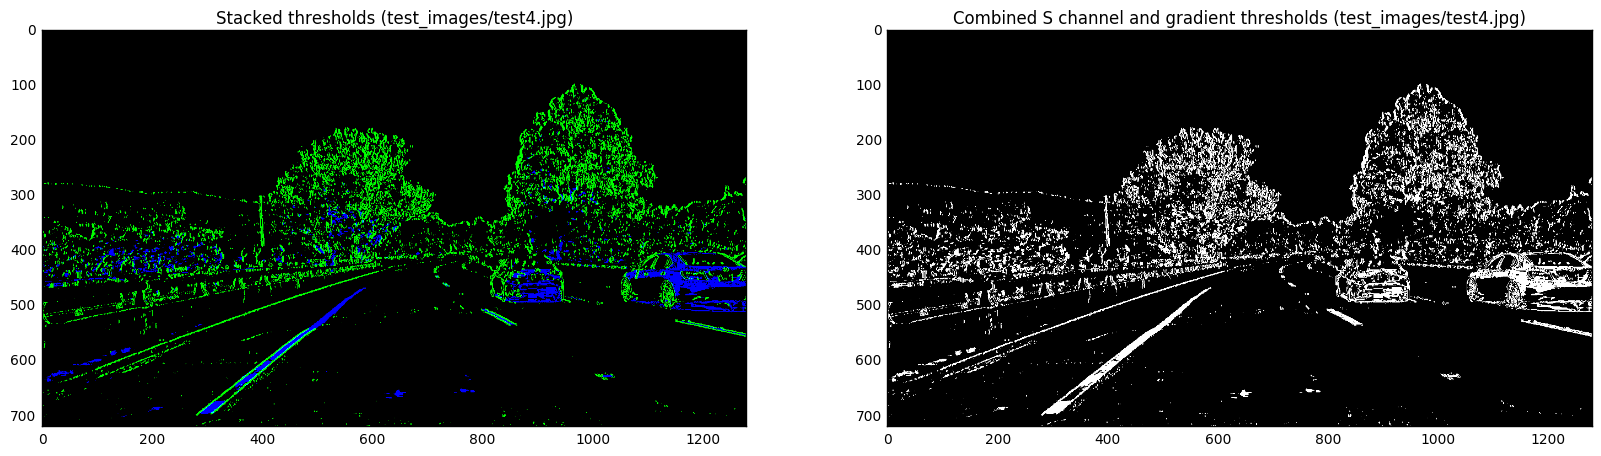

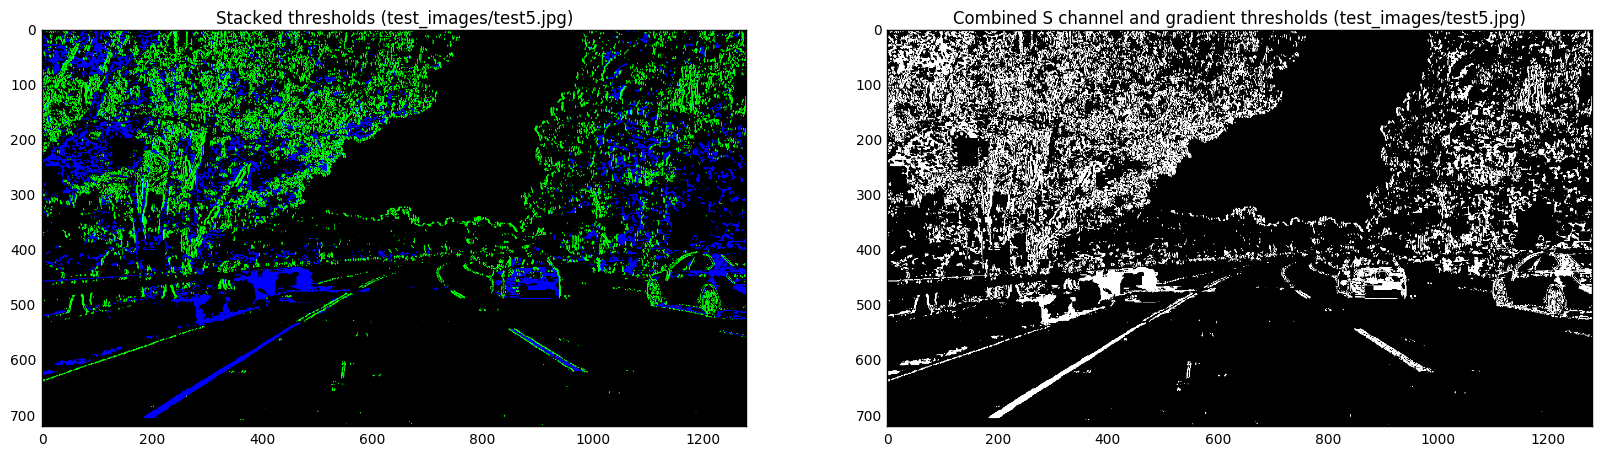

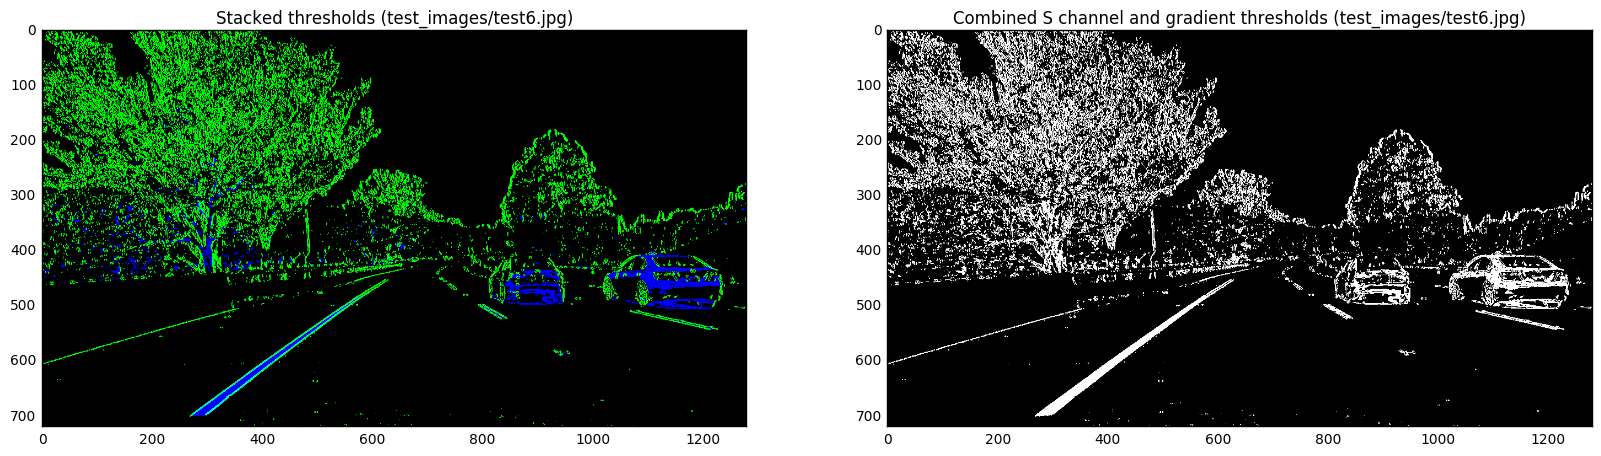

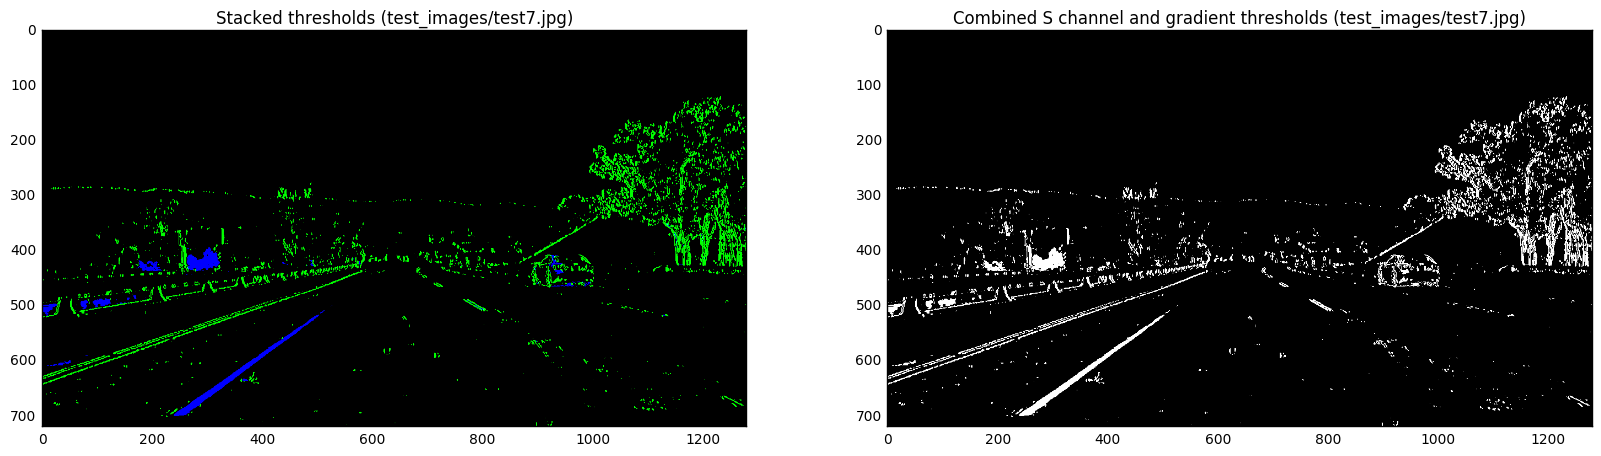

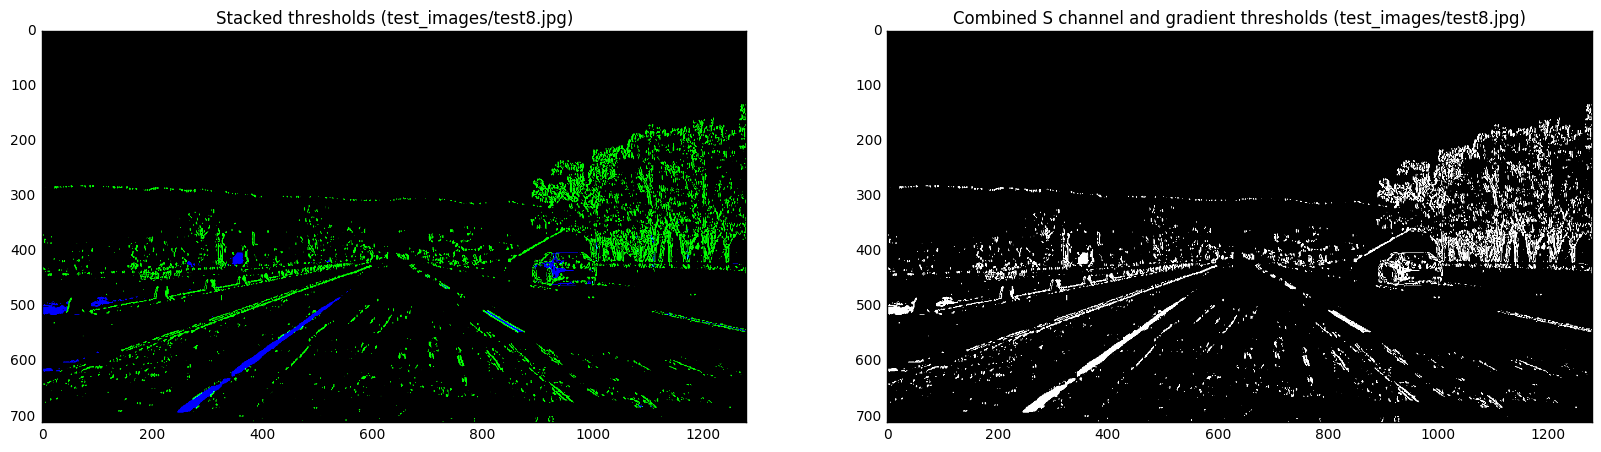

In [7]:
# Test pre-pipeline with all test images
images = glob.glob('test_images/*.jpg')

for name in images:
    _, color_binary, combined_binary = pre_pipeline(cv2.imread(name))
    
    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title('Stacked thresholds ({})'.format(name))
    ax1.imshow(color_binary)

    ax2.set_title('Combined S channel and gradient thresholds ({})'.format(name))
    ax2.imshow(combined_binary, cmap='gray')
    f.savefig('pre_pipeline_{}'.format(name.split('/')[1]))

## 3. Perspective transform

In [8]:
# Transform an image into bird's-eye view
# Optionally, plot the original and the warped image, including the source and destination points
def perspective_transform(combined_binary, plot=False):
    img_size = (combined_binary.shape[1], combined_binary.shape[0])
    
    # Define source and destination points
    # (starting top left, going clockwise)
    src = np.float32([[585, img_size[1] - 270], [685, img_size[1] - 270], [1110, img_size[1]], [210, img_size[1]]])
    dst = np.float32([[(img_size[0] / 4), 0], [(img_size[0] * 3 / 4), 0], [(img_size[0] * 3 / 4), img_size[1]], [(img_size[0] / 4), img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    binary_warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)

    if plot:
        # Plot warped image
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

        ax1.set_title('Processed Image')
        ax1.imshow(combined_binary, cmap='gray')
        ax1.plot(src[0][0], src[0][1], 'ro')
        ax1.plot(src[1][0], src[1][1], 'ro')
        ax1.plot(src[2][0], src[2][1], 'ro')
        ax1.plot(src[3][0], src[3][1], 'ro')

        ax2.set_title('Warped Image')
        ax2.imshow(binary_warped, cmap='gray')
        ax2.plot(dst[0][0], dst[0][1], 'ro')
        ax2.plot(dst[1][0], dst[1][1], 'ro')
        ax2.plot(dst[2][0], dst[2][1], 'ro')
        ax2.plot(dst[3][0], dst[3][1], 'ro')
        
        f.savefig('warped.jpg')
    
    return binary_warped, M_inv

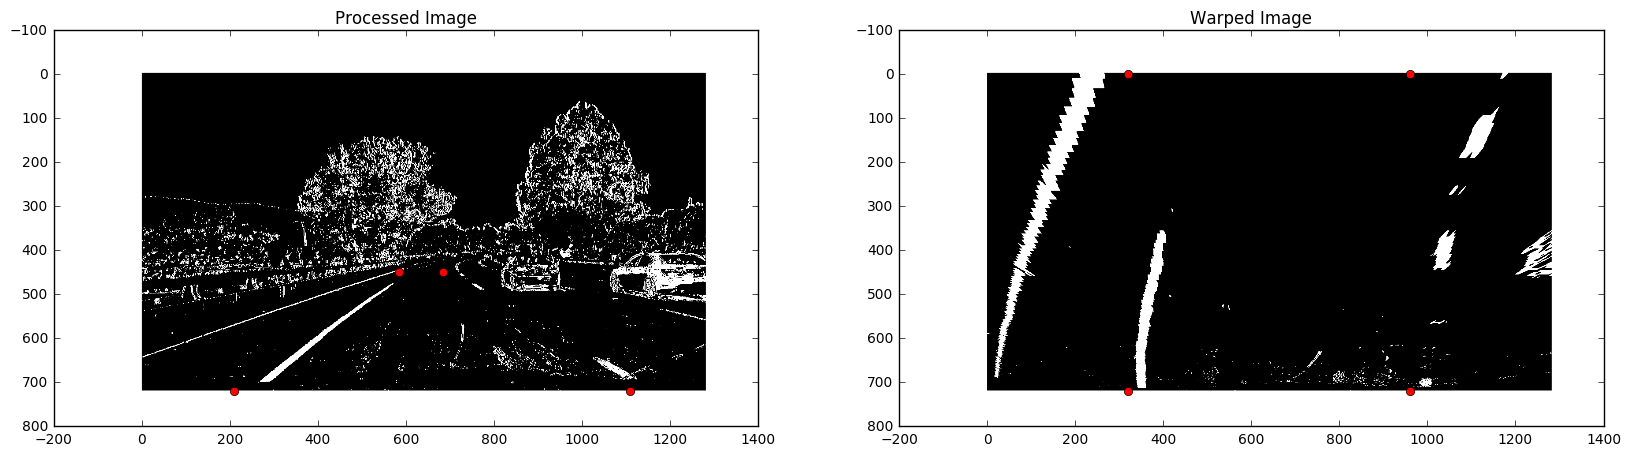

In [9]:
# Test persepctive transform
rgb_undist, _, combined_binary = pre_pipeline(cv2.imread('test_images/test1.jpg'))
binary_warped, M_inv = perspective_transform(combined_binary, plot=True)

## 4. Finding lane lines

In [10]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30 / 720 # meters per pixel in y dimension
xm_per_pix = 3.7 / 700 # meters per pixel in x dimension

In [11]:
# Helper to quickly solve second degree polynoms
def solve(y, poly):
    return poly[0] * y**2 + poly[1] * y + poly[2]

### Thorough approach

In [12]:
# Find lane lins in a binary image using the histogram approach
# Optionally, plot a visualization and the histogram
def find_lane_lines_init(binary_warped, plot=False):

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0] / 2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    # Improvement: discard very left/right parts of the image/road
    midpoint = np.int(histogram.shape[0] / 2)
    left = np.int(histogram.shape[0] * 0.1)
    right = np.int(histogram.shape[0] * 0.9)
    leftx_base = np.argmax(histogram[left:midpoint]) + left
    rightx_base = np.argmax(histogram[midpoint:right]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 50

    # Set minimum number of pixels found to recenter window
    minpix = 80

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high,win_y_high), (0, 255, 0), 2) 
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high,win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit in m
    left_fit_m = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_m = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = solve(ploty, left_fit)
    right_fitx = solve(ploty, right_fit)
        
    if plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        ax1.set_title('Visualization of the algorithm')
        ax1.imshow(out_img)
        ax1.plot(left_fitx, ploty, color='yellow')
        ax1.plot(right_fitx, ploty, color='yellow')

        ax2.set_title('Histogram, with both base points')
        ax2.plot(histogram)
        ax2.plot(leftx_base, 0, 'ro')
        ax2.plot(rightx_base, 0, 'ro')
        
        f.savefig('lane_lines.jpg')
    
    return left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty

/Users/B/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


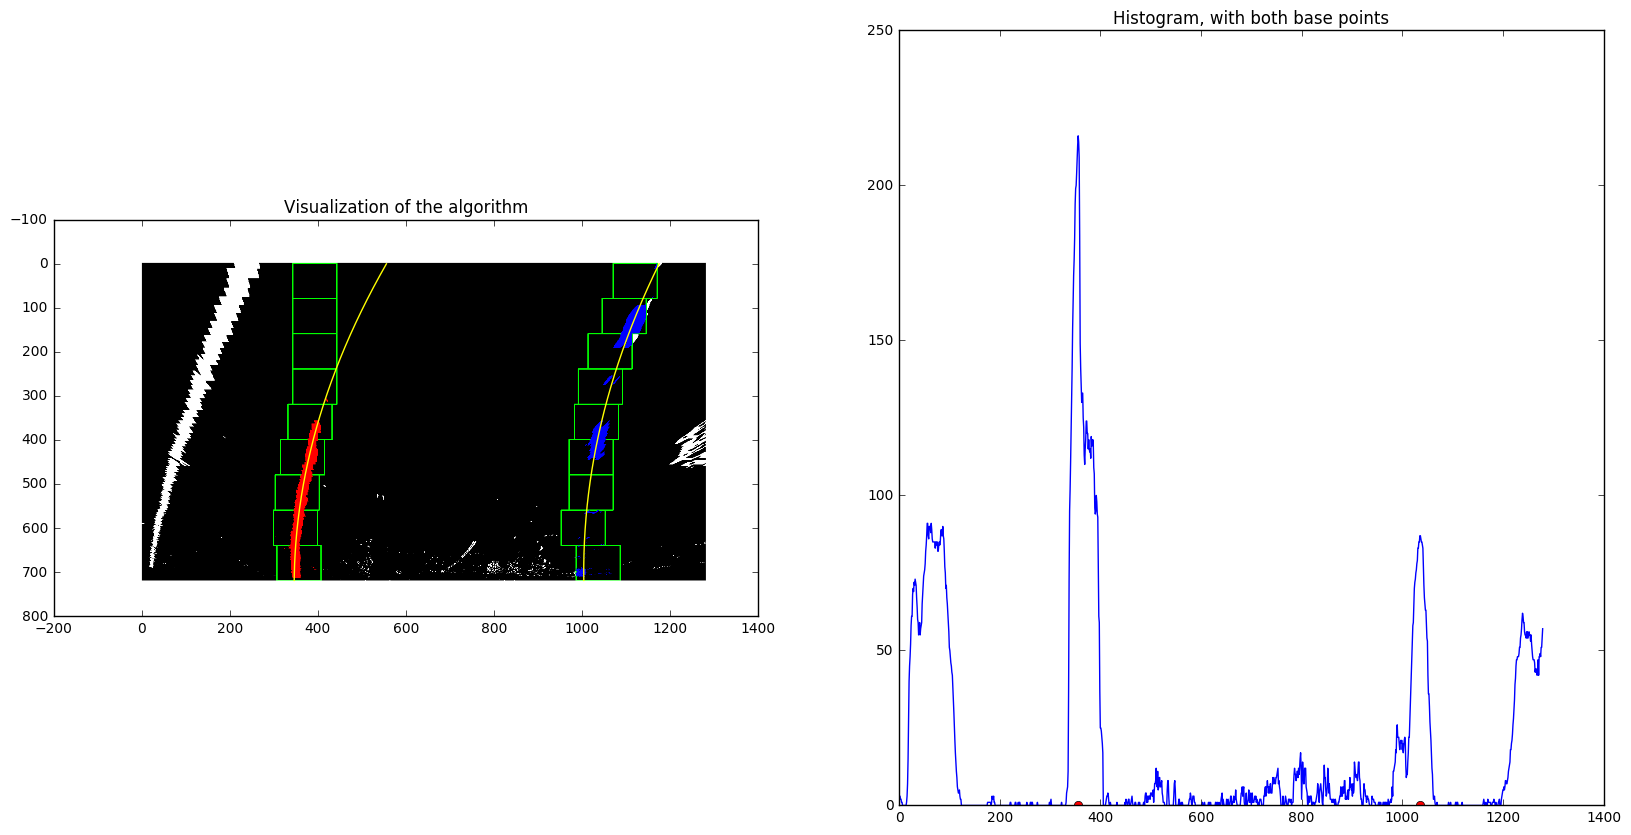

In [13]:
# Test it
left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty = find_lane_lines_init(binary_warped, plot=True)

### Optimized approach

In [14]:
# Optimized algorithm, when intitial fits already exist
# Optionally, plot a visualization
def find_lane_lines_2(binary_warped, left_fit, right_fit, plot=False):

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the width of the windows +/- margin
    margin = 50
    
    # Identify the nonzero pixels in x and y within the window
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy**2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy**2) + left_fit[1] * nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit in m
    left_fit_m = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_m = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = solve(ploty, left_fit)
    right_fitx = solve(ploty, right_fit)
        
    if plot:       
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        plt.savefig('lane_lines_2.jpg')
        
    return left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty

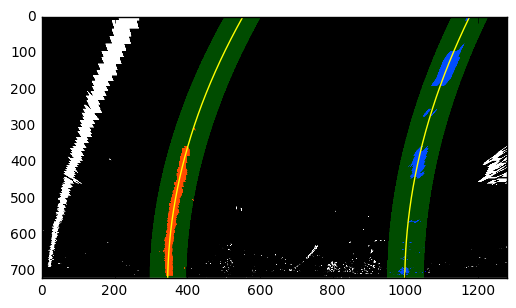

In [15]:
# Test it
left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty = find_lane_lines_2(binary_warped, left_fit, right_fit, plot=True)

### Curvature & Offset

In [16]:
# Calculate the curve radius in m
def calc_curve_rad_m(left_fit, right_fit, ploty):

    # Define y-value where we want radius of curvature (bottom of image)
    y_eval = np.max(ploty)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1])**2)**1.5) / np.absolute(2 * left_fit[0])
    right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1])**2)**1.5) / np.absolute(2 * right_fit[0])

    return round(left_curverad, 2), round(right_curverad, 2)

In [17]:
# Test curve radius calculation
left_curverad, right_curverad = calc_curve_rad_m(left_fit_m, right_fit_m, ploty)

print(left_curverad, 'm', right_curverad, 'm')

2857.25 m 2509.56 m


In [18]:
# Calculate the offset between car and the lane center
def calc_offset(left_fit, right_fit, img_size):
    left_lane_x = solve(img_size[0], left_fit)
    right_lane_x = solve(img_size[0], right_fit)

    lane_center = (left_lane_x + right_lane_x) / 2.0

    return round((lane_center - img_size[0] / 2) * xm_per_pix, 2)


In [19]:
# Test offset calculation
print('Offset: ', calc_offset(left_fit, right_fit, (rgb_undist.shape[1], rgb_undist.shape[0])), 'm')

Offset:  0.73 m


## 5. Augment the Image

In [20]:
# Add the text overlay to an image
def text_overlay(image, left_fit, right_fit, left_fit_m, right_fit_m, ploty, original_image):
    left_curverad, right_curverad = calc_curve_rad_m(left_fit_m, right_fit_m, ploty)
    offset = calc_offset(left_fit, right_fit, (original_image.shape[1], original_image.shape[0]))

    text = 'Left: ' + str(left_curverad) + 'm, right: ' + str(right_curverad) + 'm. Offset: ' + str(offset) + 'm'
    cv2.putText(image, text, (10, 50), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2, cv2.LINE_AA)

In [21]:
# Augment an image with the lane and additional text
def augment_image(binary_warped, left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty, M_inv, original_image, plot=False):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, M_inv, (original_image.shape[1], original_image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, new_warp, 0.3, 0)

    # Add curvature and offset information
    text_overlay(result, left_fit, right_fit, left_fit_m, right_fit_m, ploty, original_image)

    if plot:
        plt.imshow(result)
        plt.savefig('final.jpg')
    
    return result

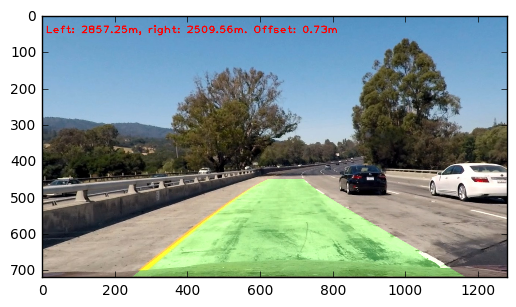

In [22]:
# Test image augmentation
result = augment_image(binary_warped, left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty, M_inv, rgb_undist, plot=True)

## 6. Final Pipeline

In [23]:
# Settings for smoothing
smoothing = True
smooth_buffer_size = 12

# Settings for sanity check
lane_width = 700
lane_width_deviation = 200
insane_patience = 5

In [24]:
# Check if lane lines are separated by reasonable distance
# (check performed at bottom and top, as well as in the middle of the image)
def sanity_check(left_fit, right_fit, height):
    a_l = solve(height, left_fit)
    b_l = solve(height / 2, left_fit)
    c_l = solve(0, left_fit)
    
    a_r = solve(height, right_fit)
    b_r = solve(height / 2, right_fit)
    c_r = solve(0, right_fit)
    
    bot_dist_sane = lane_width - lane_width_deviation < (a_r - a_l) < lane_width + lane_width_deviation
    mid_dist_sane = lane_width - lane_width_deviation < (b_r - b_l) < lane_width + lane_width_deviation
    top_dist_sane = lane_width - lane_width_deviation < (c_r - c_l) < lane_width + lane_width_deviation
    
    return bot_dist_sane and mid_dist_sane and top_dist_sane

In [25]:
def pipeline(image):
    global left_fit
    global right_fit
    
    global left_fit_avg
    global right_fit_avg
    global left_fitx_avg
    global right_fitx_avg
    global ploty_avg
    
    global step
    global counter
    global rejection_counter
    global enough
    
    global insane_in_row
    global insane_patience
    
    counter += 1
    
    # 1. Process image to create a thresholded binary image where (ideally) only lane lines are visible in white
    rgb_undist, _, combined_binary = pre_pipeline(image, is_rgb=True)
    
    # 2. Warp image
    binary_warped, M_inv = perspective_transform(combined_binary)
    
    # 3. Find lane lines in image and return their curves (use more advanced technique if there was a previous frame)
    # Also reset if too many frames in a row did not pass the sanity check
    if (left_fit is not None and right_fit is not None) and insane_in_row < insane_patience:        
        left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty = find_lane_lines_2(binary_warped, left_fit, right_fit, plot=False)
    else:
        left_fit_avg = np.empty(smooth_buffer_size, dtype=object)
        right_fit_avg = np.empty(smooth_buffer_size, dtype=object)
        left_fitx_avg = np.empty(smooth_buffer_size, dtype=object)
        right_fitx_avg = np.empty(smooth_buffer_size, dtype=object)
        ploty_avg = np.empty(smooth_buffer_size, dtype=object)
        enough = False
        step = 0
        insane_in_row = 0
        
        left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty = find_lane_lines_init(binary_warped, plot=False)
    
    # Sanity check
    if sanity_check(left_fit, right_fit, image.shape[0]):
        left_fit_avg[step] = left_fit
        right_fit_avg[step] = right_fit
        left_fitx_avg[step] = left_fitx
        right_fitx_avg[step] = right_fitx
        ploty_avg[step] = ploty

        step += 1
    else:
        rejection_counter += 1
        insane_in_row += 1            
        
    if step >= smooth_buffer_size:
        enough = True
        step = 0
        
    # Smooth by averaging if enabled and enough frames captured
    if enough and smoothing:
        left_fit = np.mean(left_fit_avg)
        right_fit = np.mean(right_fit_avg)
        left_fitx = np.mean(left_fitx_avg)
        right_fitx = np.mean(right_fitx_avg)
        ploty = np.mean(ploty_avg)

    # 4. Augment image with lane and text overlays
    return augment_image(binary_warped, left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty, M_inv, rgb_undist, plot=False)


### Processing the video

In [26]:
# Import everything needed to edit and save video clips
from moviepy.editor import VideoFileClip

In [27]:
# Initialize variables
left_fit = None
right_fit = None

left_fit_avg = np.empty(smooth_buffer_size, dtype=object)
right_fit_avg = np.empty(smooth_buffer_size, dtype=object)
left_fitx_avg = np.empty(smooth_buffer_size, dtype=object)
right_fitx_avg = np.empty(smooth_buffer_size, dtype=object)
ploty_avg = np.empty(smooth_buffer_size, dtype=object)

step = 0
counter = 0
rejection_counter = 0
enough = False
insane_in_row = 0

# Create output name string
output = 'output' + str(smoothing) + '_' + str(smooth_buffer_size) + '_' + str(lane_width_deviation) + '_' + str(insane_patience) + '.mp4'

# Process video
clip1 = VideoFileClip('project_video.mp4')
#clip1 = VideoFileClip('project_video.mp4').subclip(18, 26)
clip = clip1.fl_image(pipeline)
%time clip.write_videofile(output, audio=False)

# Print some stats
print('Total frames: ', counter)
print('Rejected: ', rejection_counter)

[MoviePy] >>>> Building video outputTrue_12_200_5.mp4
[MoviePy] Writing video outputTrue_12_200_5.mp4


100%|█████████▉| 1260/1261 [02:52<00:00,  7.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: outputTrue_12_200_5.mp4 

CPU times: user 3min 20s, sys: 48.8 s, total: 4min 9s
Wall time: 2min 53s
Total frames:  1261
Rejected:  58
